In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
CLS2IDX={0:"Bacterial_Pneumonia_segmented",
         1:"Covid_segmented", 
         2:"Normal_segmented",
         3:"Viral_Pneumonia_segmented"}

/home/jsuri/.conda/envs/torch_clone/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


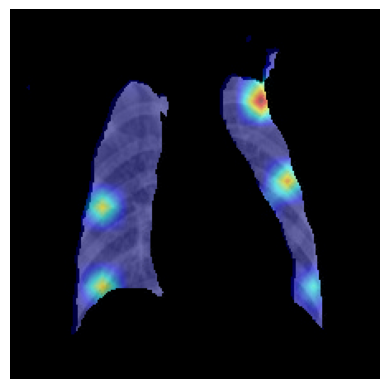

: 

In [6]:
from baselines.ViT.ViT_LRP import vit_large_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP

from torchvision.transforms import Lambda

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x),
    normalize,
])


# create heatmap from mask on image
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam

# initialize ViT pretrained with DeiT
model = vit_LRP(num_classes=4).cuda()
# Load the state dict as it is
state_dict = torch.load('vit_large_model_epoch10.pth')

# Remove 'module.' prefix
new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}

# Load the adjusted state dict
model.load_state_dict(new_state_dict)
model.eval()
attribution_generator = LRP(model)

def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
    transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis
# Load and transform the image
image = Image.open('Bacterial_Pneumonia_segmented/person1666_bacteria_4416.jpg')
transformed_image = transform(image)
# Generate heatmap visualizatio
heatmap = generate_visualization(transformed_image)
mask_path = "Bacterial_Pneumonia_mask/Pred_person1666_bacteria_4416.jpg"
mask_image = Image.open(mask_path).convert('L')  # Ensure mask is in grayscale
mask_image = mask_image.resize((224, 224))  # Resize mask to match heatmap
mask = np.array(mask_image)
mask = mask.astype(np.float32) / 255  # Normalize mask
# Ensure mask is the correct shape (224,224,3)
mask = np.stack((mask,)*3, axis=-1)
# Apply the mask to the heatmap visualization
masked_heatmap = heatmap * mask  # This will broadcast correctly
# Display the masked heatmap
fig, axs = plt.subplots(1, 1)
axs.imshow(masked_heatmap.astype(np.uint8))  # Convert back to uint8 for display
axs.axis('off')
plt.show()